In [1]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


In [5]:
import praw
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from datetime import datetime
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
SUBREDDITS = ['Entrepreneur', 'SaaS', 'startups', 'freelance', 'smallbusiness']
INDIEHACKERS_URL = "https://www.indiehackers.com/search?topics=Help%20me%20with,Is%20there%20a%20tool,I%27m%20stuck%20with"
USER_AGENT = "MicroSaaS Ideas Miner/1.0"
LIMIT = 150  
OUTPUT_FILE = r"C:\Users\Welcome\OneDrive\Pictures\Desktop\Phase 2\project 1\microsaas_ideas dataset.txt"
reddit = praw.Reddit(
    client_id="YOUR_CLIENT_ID",
    client_secret="YOUR_CLIENT_SECRET",
    user_agent=USER_AGENT
)
def scrape_reddit():
    """Scrape problem-related posts from Reddit"""
    posts = []
    for subreddit in SUBREDDITS:
        try:
            for submission in reddit.subreddit(subreddit).search('"I need" OR "pain point" OR "problem with" OR "frustrated with" OR "manual process"', limit=50, sort='relevance'):
                if submission.stickied or submission.promoted:
                    continue
                title = submission.title.replace('\n', ' ').strip()
                text = submission.selftext.replace('\n', ' ').strip()
                if len(text) < 50 and len(title) < 20:
                    continue             
                posts.append({
                    'platform': 'Reddit',
                    'raw_post': f"{title}. {text}"[:500],  
                    'url': f"https://reddit.com{submission.permalink}",
                    'date': datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d')
                })
                if len(posts) >= LIMIT//2:
                    break
        except Exception as e:
            print(f"Error scraping {subreddit}: {e}")
    return posts
def scrape_indiehackers():
    """Scrape problem-related posts from IndieHackers"""
    posts = []
    try:
        response = requests.get(INDIEHACKERS_URL, headers={'User-Agent': USER_AGENT})
        soup = BeautifulSoup(response.text, 'html.parser')
        post_cards = soup.find_all('div', class_='post-card__content')
        for card in post_cards[:LIMIT//2]:
            title = card.find('h3').get_text().strip()
            url = "https://www.indiehackers.com" + card.find('a')['href']
            try:
                post_response = requests.get(url, headers={'User-Agent': USER_AGENT})
                post_soup = BeautifulSoup(post_response.text, 'html.parser')
                content = post_soup.find('div', class_='post__content').get_text().strip()
                date_element = post_soup.find('time')
                date = date_element['datetime'][:10] if date_element else "2024-01-01"
                posts.append({
                    'platform': 'IndieHackers',
                    'raw_post': f"{title}. {content}"[:500],
                    'url': url,
                    'date': date
                })
                time.sleep(1)  
            except Exception as e:
                print(f"Error scraping post {url}: {e}")
    except Exception as e:
        print(f"Error scraping IndieHackers: {e}")
    return posts
def collect_data():
    """Collect data from both sources"""
    reddit_posts = scrape_reddit()
    indiehackers_posts = scrape_indiehackers()
    all_posts = reddit_posts + indiehackers_posts
    return pd.DataFrame(all_posts)
df = collect_data()
df.to_csv(OUTPUT_FILE, index=False)
print(f"Collected {len(df)} posts. Data saved to {OUTPUT_FILE}")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Welcome\AppData\Roaming\nltk_data...


Error scraping Entrepreneur: received 401 HTTP response
Error scraping SaaS: received 401 HTTP response
Error scraping startups: received 401 HTTP response
Error scraping freelance: received 401 HTTP response
Error scraping smallbusiness: received 401 HTTP response
Collected 0 posts. Data saved to C:\Users\Welcome\OneDrive\Pictures\Desktop\Phase 2\project 1\microsaas_ideas dataset.txt


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

df = pd.read_csv(r'C:\Users\Welcome\OneDrive\Pictures\Desktop\Phase 2\project 1\microSaaS_ideas_dataset.csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nColumns and data types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (500, 7)

First few rows:
        Name                           URL  \
0   LinkedIn          https://linkedin.com   
1     Google            https://google.com   
2     Google  https://googletagmanager.com   
3     GitHub            https://github.com   
4  WordPress         https://wordpress.org   

                                           Type              Category  \
0                                b2b, b2c, saas          social media   
1                    b2b, b2c, e-commerce, saas                   law   
2  b2b, b2c, saas, service-provider, e-commerce            technology   
3                                b2b, b2c, saas  software development   
4                                b2c, b2b, saas              software   

                                            Keywords  \
0  professional networking, talent acquisition, j...   
1               law firm, legal services, retirement   
2  search engine, online advertising, cloud compu...   
3  version control,

In [24]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'[^\w\s]', '', text)  
    text = text.lower()  
    return text
df['Description'] = df['Description'].apply(clean_text)
df['Keywords'] = df['Keywords'].apply(clean_text)
df['Category'] = df['Category'].apply(clean_text)
def extract_keywords(keyword_str):
    if pd.isna(keyword_str):
        return []
    return [kw.strip() for kw in keyword_str.split(',')]
df['Keyword_List'] = df['Keywords'].apply(extract_keywords)
keywords_df = df.explode('Keyword_List')


Top 20 Keywords:
professional networking talent acquisition job search marketing solutions industry insights: 1
law firm legal services retirement: 1
search engine online advertising cloud computing internet mobile software: 1
version control collaboration repository hosting software security developer tools: 1
web publishing content management blogging open source website creation: 1
video platform video sharing content creation video hosting creative tools: 1
finance social networking digital payments innovation security: 1
digital platform link management social media content creators digital presence: 1
membership platform creator community exclusive content fan support monetization financial freedom: 1
cloud storage file sharing collaboration tools remote work data management: 1
software cloud computing search engine enterprise solutions: 1
online retail payment processing store management digital commerce: 1
payment processing e commerce saas business growth: 1
content creators 

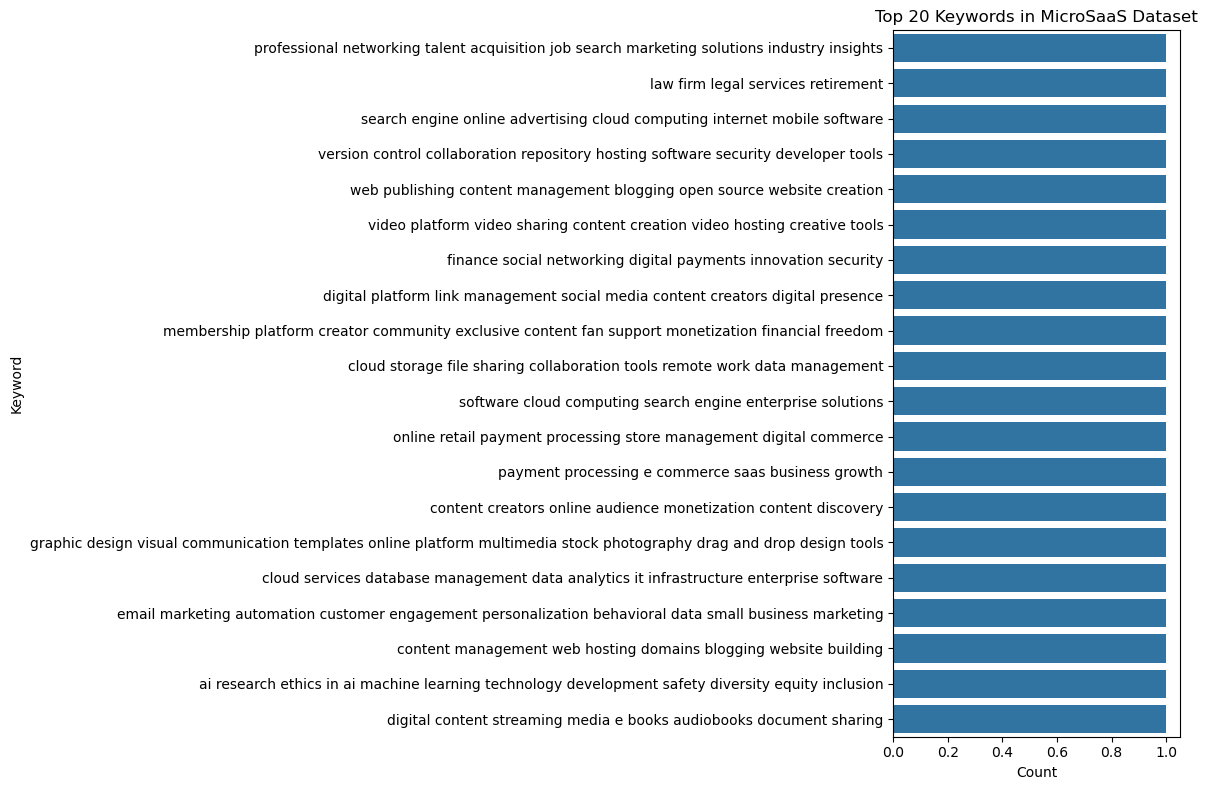

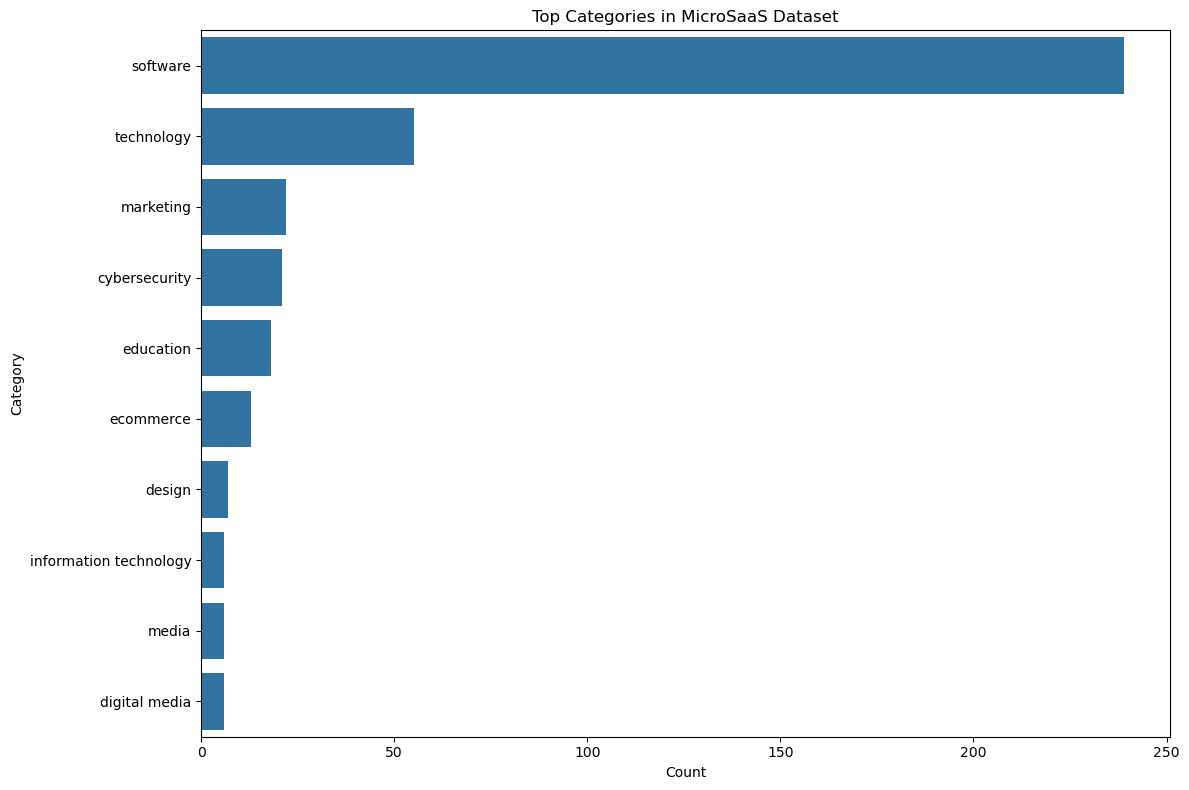

In [23]:
keyword_counts = Counter(keywords_df['Keyword_List'].dropna())
top_keywords = keyword_counts.most_common(20)
print("\nTop 20 Keywords:")
for kw, count in top_keywords:
    print(f"{kw}: {count}")
category_counts = df['Category'].value_counts().head(10)
print("\nTop Categories:")
print(category_counts)
plt.figure(figsize=(12, 8))
sns.barplot(x=[count for kw, count in top_keywords], 
            y=[kw for kw, count in top_keywords])
plt.title('Top 20 Keywords in MicroSaaS Dataset')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.tight_layout()
plt.savefig('top_keywords.png')
plt.show()
plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts.values, y=category_counts.index)
plt.title('Top Categories in MicroSaaS Dataset')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.savefig('top_categories.png')
plt.show()


Top Potential Gaps:
matter their skill level with a wealth of tutorials and dedicated support available techsmith aims to transform the way content is created and shared enhancing user engagement and information retention: 1
technical expertise in audio editing making it accessible for both amateurs and professionals auphonic supports multiple audio formats and offers features like chapter marks and automated content deployment to popular platforms: 1
additional setup or configuration making it ideal for applications embedded systems and development environments the company is based in the united states and serves a global market with its innovative database: 1
signup it offers a userfriendly interface similar to document editing enabling advanced features such as payment collection calculations form logic and answer piping tally is designed for individuals and businesses seeking a simple yet powerful solution for gathering responses: 1
extensive inhouse testing infrastructure serving

C:\Users\Welcome\AppData\Local\Temp\ipykernel_18556\3109564404.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


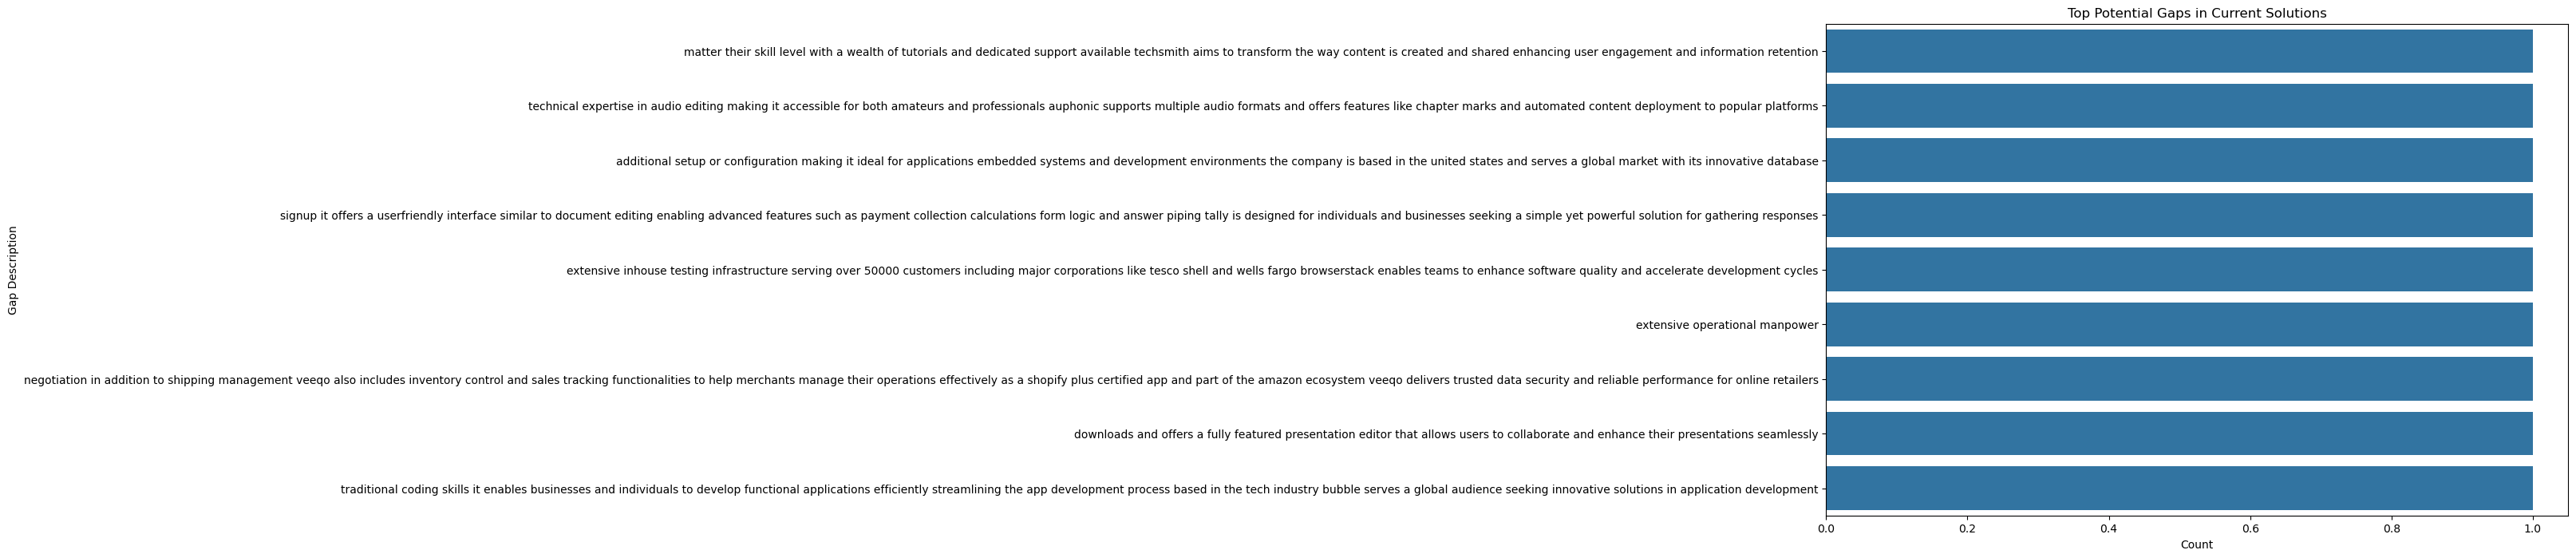

In [25]:
def find_gaps(description):
    gaps = []
    if 'lack of' in description:
        gaps.append(description.split('lack of')[1].split('.')[0].strip())
    if 'no ' in description and 'solution' in description:
        gaps.append(description.split('no ')[1].split('solution')[0].strip())
    if 'need for' in description:
        gaps.append(description.split('need for')[1].split('.')[0].strip())
    if 'problem with' in description:
        gaps.append(description.split('problem with')[1].split('.')[0].strip())
    return gaps
df['Potential_Gaps'] = df['Description'].apply(find_gaps)
gaps_df = df.explode('Potential_Gaps')
gap_counts = Counter(gaps_df['Potential_Gaps'].dropna())
top_gaps = gap_counts.most_common(15)
print("\nTop Potential Gaps:")
for gap, count in top_gaps:
    if gap:  
        print(f"{gap}: {count}")
plt.figure(figsize=(12, 8))
sns.barplot(x=[count for gap, count in top_gaps if gap], 
            y=[gap for gap, count in top_gaps if gap])
plt.title('Top Potential Gaps in Current Solutions')
plt.xlabel('Count')
plt.ylabel('Gap Description')
plt.tight_layout()
plt.savefig('top_gaps.png')
plt.show()

In [26]:
def generate_ideas(row):
    ideas = []
    name = row['Name']
    category = row['Category']
    keywords = row['Keyword_List']
    gaps = row['Potential_Gaps']
    
    if category and keywords:
        ideas.append(f"Niche {category} tool focusing on {keywords[0]}")
    
    if len(keywords) > 1:
        ideas.append(f"Tool combining {keywords[0]} and {keywords[1]}")
    
    for gap in gaps:
        if gap:
            ideas.append(f"Solution for {gap} in {category}")
    
    return ideas

df['MicroSaaS_Ideas'] = df.apply(generate_ideas, axis=1)
ideas_df = df.explode('MicroSaaS_Ideas')

unique_ideas = ideas_df['MicroSaaS_Ideas'].dropna().unique()

print("\nGenerated MicroSaaS Ideas:")
for i, idea in enumerate(unique_ideas[:20], 1):
    print(f"{i}. {idea}")

with open('microsaas_ideas.txt', 'w') as f:
    f.write("Top MicroSaaS Ideas Generated:\n\n")
    for i, idea in enumerate(unique_ideas[:50], 1):
        f.write(f"{i}. {idea}\n")


Generated MicroSaaS Ideas:
1. Niche social media tool focusing on professional networking talent acquisition job search marketing solutions industry insights
2. Niche law tool focusing on law firm legal services retirement
3. Niche technology tool focusing on search engine online advertising cloud computing internet mobile software
4. Niche software development tool focusing on version control collaboration repository hosting software security developer tools
5. Niche software tool focusing on web publishing content management blogging open source website creation
6. Niche media tool focusing on video platform video sharing content creation video hosting creative tools
7. Niche technology tool focusing on finance social networking digital payments innovation security
8. Niche technology tool focusing on digital platform link management social media content creators digital presence
9. Niche digital media tool focusing on membership platform creator community exclusive content fan supp

In [27]:
def create_report():
    report = """
# MicroSaaS Opportunities Analysis Report
## 1. Dataset Overview
- Total entries: {total_entries}
- Categories represented: {num_categories}
- Unique keywords: {num_keywords}
## 2. Key Findings
### Top Categories:
{top_categories}
### Most Common Keywords:
{top_keywords}
### Identified Gaps in Current Solutions:
{top_gaps}
## 3. Recommended MicroSaaS Opportunities
Based on the analysis, here are the most promising MicroSaaS opportunities:
### High Potential Ideas:
1. {idea1}
2. {idea2}
3. {idea3}
4. {idea4}
5. {idea5}
### Niche-Specific Opportunities:
6. {idea6}
7. {idea7}
8. {idea8}
9. {idea9}
10. {idea10}
## 4. Next Steps
- Validate top ideas with target users
- Research existing solutions in recommended niches
- Prioritize opportunities based on market size and competition
""".format(
        total_entries=len(df),
        num_categories=df['Category'].nunique(),
        num_keywords=len(keyword_counts),
        top_categories='\n'.join([f"- {cat}: {count}" for cat, count in category_counts.items()]),
        top_keywords='\n'.join([f"- {kw}: {count}" for kw, count in top_keywords]),
        top_gaps='\n'.join([f"- {gap}: {count}" for gap, count in top_gaps if gap]),
        idea1=unique_ideas[0],
        idea2=unique_ideas[1],
        idea3=unique_ideas[2],
        idea4=unique_ideas[3],
        idea5=unique_ideas[4],
        idea6=unique_ideas[5],
        idea7=unique_ideas[6],
        idea8=unique_ideas[7],
        idea9=unique_ideas[8],
        idea10=unique_ideas[9]
    )
    with open('microsaas_analysis_report.md', 'w') as f:
        f.write(report)
    return report
print(create_report())


# MicroSaaS Opportunities Analysis Report
## 1. Dataset Overview
- Total entries: 500
- Categories represented: 71
- Unique keywords: 500
## 2. Key Findings
### Top Categories:
- software: 239
- technology: 55
- marketing: 22
- cybersecurity: 21
- education: 18
- ecommerce: 13
- design: 7
- information technology: 6
- media: 6
- digital media: 6
### Most Common Keywords:
- professional networking talent acquisition job search marketing solutions industry insights: 1
- law firm legal services retirement: 1
- search engine online advertising cloud computing internet mobile software: 1
- version control collaboration repository hosting software security developer tools: 1
- web publishing content management blogging open source website creation: 1
- video platform video sharing content creation video hosting creative tools: 1
- finance social networking digital payments innovation security: 1
- digital platform link management social media content creators digital presence: 1
- membershi

In [29]:
export_df = df[['Name', 'URL', 'Type', 'Category', 'Keywords', 'Description']].copy()
export_df['MicroSaaS_Ideas'] = df['MicroSaaS_Ideas'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
export_df.to_csv(r'C:\Users\Welcome\OneDrive\Pictures\Desktop\Phase 2\project 1\microsaas_dataset opp.csv', index=False)
print("\nData exported to microsaas_opportunities.csv for Google Sheets import")


Data exported to microsaas_opportunities.csv for Google Sheets import


In [30]:
def analyze_opportunities():
    category_gaps = {}
    for category in df['Category'].unique():
        category_count = len(df[df['Category'] == category])
        if category_count < 5:  
            category_gaps[category] = category_count
    keyword_pairs = []
    for i in range(len(keywords_df)):
        for j in range(i+1, min(i+5, len(keywords_df))):
            if keywords_df.iloc[i]['Name'] == keywords_df.iloc[j]['Name']:
                continue
            pair = (keywords_df.iloc[i]['Keyword_List'], keywords_df.iloc[j]['Keyword_List'])
            keyword_pairs.append(pair)
    pair_counts = Counter(keyword_pairs)
    top_pairs = pair_counts.most_common(10) 
    integration_opportunities = []
    for _, row in df.iterrows():
        if 'integration' in row['Description'] or 'api' in row['Description'].lower():
            integration_opportunities.append(row['Name'])   
    opportunities_report = """
{underserved_categories}
{feature_pairs}
{integrations}
{problem_areas}
""".format(
        underserved_categories='\n'.join([f"- {cat}: Only {count} solutions" for cat, count in category_gaps.items()]),
        feature_pairs='\n'.join([f"- {pair[0]} + {pair[1]}: {count} co-occurrences" for pair, count in top_pairs]),
        integrations='\n'.join([f"- {name}" for name in integration_opportunities[:10]]),
        problem_areas='\n'.join([f"- {gap}: {count} mentions" for gap, count in top_gaps if gap and count > 1])
    )
    with open('detailed_opportunities_analysis.md', 'w') as f:
        f.write(opportunities_report)
    return opportunities_report
print(analyze_opportunities())


- social media: Only 1 solutions
- law: Only 1 solutions
- software development: Only 4 solutions
- financial services: Only 3 solutions
- digital publishing: Only 2 solutions
- tech: Only 2 solutions
- artificial intelligence: Only 2 solutions
- web development: Only 1 solutions
- communication: Only 1 solutions
- human resources: Only 2 solutions
- information services: Only 3 solutions
- online reviews: Only 1 solutions
- legal services: Only 4 solutions
- employment services: Only 1 solutions
- data services: Only 2 solutions
- music: Only 1 solutions
- data analytics: Only 1 solutions
- music licensing: Only 1 solutions
- it services: Only 1 solutions
- online services: Only 1 solutions
- hosting: Only 1 solutions
- professional services: Only 1 solutions
- interior design: Only 1 solutions
- analytics: Only 3 solutions
- healthcare: Only 4 solutions
- cloud computing: Only 1 solutions
- geophysics: Only 1 solutions
- online analytics: Only 1 solutions
- podcasting: Only 1 soluti